# Plots Paper: Thai et al. 2025 - all created Python plots 

## A) Overview

With this .ipynb-Notebook, the plots for the paper Thai et al. 2025 were created.
The data was taken from my excel "All_data.xlsx", which is a summary excel sheet, containing all important data.
During this study, many versions (internal naming: Dataset001, Dataset002, ..., Dataset010) have been tested. This final version "Dataset010" was the one reported in this study.

In [1]:
### all modules needed in this notebook
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from matplotlib.ticker import ScalarFormatter
import matplotlib.ticker as ticker
import statsmodels.api as sm
import re

## B) PARAMETERS THAT NEED TO BE ADATPTED

In [2]:
### READ IN EXCEL AND SHIFT ROW INDICES TO MATCH THE EXCEL SHEET
##################ADAPT###########################
# path of the excel sheet
excel_path='All_data.xlsx'
# how many columns the last dataset contains, here e.g. dataset010 has 16 columns
lastdataset_columns=16

# dataset from (ID) to (ID) that we want to analyze
dataset_start_ID=2
dataset_end_ID=10
dataset_ids_one_selected=[10] #010 for selected datasets e.g. #tracks

# all available doses (including background) and their systematical errors
doses=np.array([0,1,5,10,15,50,100]) #in mSv
doses_err=doses*0.083/2 # in mSv #8.3% from Section 2.1.1 MedPhys Paper Stefan
# columns of AmBe that are interesting for me: Background, 1, 5, 10, 15, 50, 100 mSv
col_indices = range(1, 7+1)  # columns 1..7
# color for the bar plots
colors = ["#000000","#666666", "#2258140A", "#73CE36", "#fdd007", "#db1913", "#ff00ea"]  # 7 colors

# doses (without background) and their systematical errors
doses_matlab = np.array([1,5,10,15,50,100])
doses_matlab_err = doses_matlab * 0.083/2
trackdensity_matlab = np.array([1900,13000,23033,38233,122433,236400])
trackdensity_matlab_err = np.array([473,529,857,733,1697,5519])

# folds for validation datat
folds = ["1.","2.","3.","4.","5.","CV", ""]
# columns of PTB that are interesting for me: 1,2,3,4,5,all fold
Val_col_indices = range(1, 6+1)  # columns 1..6
colors_folds = ["#666666", "#2258140A", "#73CE36", "#fdd007", "#db1913", "#0400ff"] # 6 colors

# increase textsize of plots
plt.rcParams.update({'font.size': 16}) 
##################################################

## C) Preparation
### 1) Read in excel

In [3]:
# read in excel sheet as pandas dataframe without header
df = pd.read_excel(excel_path, header=None)
# shift row index such that it matches the indices in the excel
df.index=df.index+1

### 2) Get quick view of the data header

In [4]:
### VIEW EXAMPLE
# show header of dataframe to get a view of data
df.head()

,0,1,2,3,4,5,6,7,8,9,...,139,140,141,142,143,144,145,146,147,148
1,09_ML_experiment_overview,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Last updated:,05.09.25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,General:,DEFAULT SETTINGS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Date,-,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 3) Identify the Rows and Columns where a new dataset starts

In [5]:
### EXTRACT ROWS AND COLS WHERE DIFFERENT DATASETS START AND END
# find row that contains the variable "Experiment - #" in the first column
matches=df[0].astype(str).str.contains("Experiment - #")
matching_row=df[matches]
row_index=matching_row.index[0]
# get this whole row
row=df.loc[row_index]
# print the row number
print(f'"Experiment - #" in line: {row_index}')

# extract the columns that contain an integer value (the experiment number)
integer_cols=[]
for col_index, val in row.items():
    try:
        #try converting value to integer, float also treated as integers
        if pd.notna(val) and float(val).is_integer():
            integer_cols.append(col_index)
    except (ValueError, TypeError):
        # can't convert to float -> ignore
        continue
print(f'"Experiment - #" in columns: {integer_cols}')

"Experiment - #" in line: 6
"Experiment - #" in columns: [2, 3, 7, 21, 37, 53, 69, 85, 101, 117, 133]


In [6]:
### CALCULATE THE RANGES FOR THE COLUMNS FOR EACH DATASET
#first column of a dataset
dataset_start_col=np.array(integer_cols)
#last column of a dataset
dataset_end_col=(integer_cols-np.ones_like(integer_cols))[1:]
dataset_end_col=np.append(dataset_end_col,(max(integer_cols)+lastdataset_columns-1)) #+16-1 cols manually for last dataset
print(f"dataset columns start at:{dataset_start_col}")
print(f"dataset columns end at:  {dataset_end_col}")

dataset columns start at:[  2   3   7  21  37  53  69  85 101 117 133]
dataset columns end at:  [  2   6  20  36  52  68  84 100 116 132 148]


### 4) Split the whole dataframe into individual dataframes for the above selected dataset IDs

In [7]:
# split whole datasets into one dataframe per dataset 
for i in range(dataset_start_ID,dataset_end_ID+1):
    var_name=f"dataset{i:03d}"
    cols_to_select=[0]+list(range(dataset_start_col[i], dataset_end_col[i]+1))
    globals()[var_name]=df.iloc[:,cols_to_select].copy()

### 5) Visualize the header for an example dataset

In [8]:
### VISUALIZE EXAMPLE
# show e.g. dataset010 
dataset010.head()

,0,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148
1,09_ML_experiment_overview,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Last updated:,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,General:,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Date,11.07.25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 6) Manipulate the different sub dataset such that they have the same column number structure

In [9]:
### CHANGE ALL COLUMN INDICES FOR ALL SUBDATAFRAMES TO 0,1,2,3,...
# now we want all sub data frame to have the same column numbers (dataset002 has 14 cols, datasets003-010 have 16 cols)
for i in range(dataset_start_ID, dataset_end_ID + 1):
    var_name = f"dataset{i:03d}"
    dataset_df = globals()[var_name]
    
    # Reset column indices 0, 1, 2, ...
    dataset_df.columns = range(len(dataset_df.columns))
    
    # Put it back into globals()
    globals()[var_name] = dataset_df

### 7) Check if that works for two example datasets

In [10]:
### VISUALIZE EXAMPLES
# show e.g. dataset002
dataset002.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
1,09_ML_experiment_overview,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Last updated:,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,General:,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Date,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
# show e.g. dataset010
dataset010.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
1,09_ML_experiment_overview,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Last updated:,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,General:,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Date,11.07.25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 8) Check for the relevant metrics if everything is correct so far

In [12]:
### CHECK IF EXAMPLE IS CORRECT BEFORE PUTTING INTO CODE
df10_Dice_corrected=dataset010.iloc[90-1]
df10_Dice_corrected_SEM=dataset010.iloc[91-1]
df10_IoU_corrected=dataset010.iloc[93-1]
df10_IoU_corrected_SEM=dataset010.iloc[94-1]
df10_Ratio_corrected=dataset010.iloc[100-1]
df10_Ratio_corrected_SEM=dataset010.iloc[101-1]
#print(f"dataset010 Dice mean: {df10_Dice_corrected}")
#print(f"dataset010 Dice SEM: {df10_Dice_corrected_SEM}")
#print(f"dataset010 IoU mean: {df10_IoU_corrected}")
#print(f"dataset010 IoU SEM: {df10_IoU_corrected_SEM}")
#print(f"dataset010 Ratio mean: {df10_Ratio_corrected}")
#print(f"dataset010 Ratio SEM: {df10_Ratio_corrected_SEM}")

### 9) Extract the desired metrics corresponding to the lines in the excel sheet

In [13]:
### EXTRACT THE DATA FOR ALL RELEVANT METRICS FROM THE EXCEL ROWS
# store the relevant metrics in variables for all datasets
# Row indices (adjusted to zero-based by subtracting 1 where needed)
rows = {
    # individual for val data
    'Val_Dice_corrected': 44-1,      
    'Val_Dice_corrected_SEM': 45-1,
    'Val_IoU_corrected': 47-1,       
    'Val_IoU_corrected_SEM': 48-1,
    'Val_Ratio_corrected': 54-1,     
    'Val_Ratio_corrected_SEM': 55-1,
    'Val_Tracks_reference':56-1,
    'Val_Tracks_reference_SEM':57-1,
    'Val_Tracks_predicted':58-1,
    'Val_Tracks_predicted_SEM':59-1,
    'Val_Deviation_from_ref':60-1,
    'Val_Tracks_reference_minsize':61-1,
    'Val_Tracks_reference_minsize_SEM':62-1,
    'Val_Tracks_predicted_minsize':63-1,
    'Val_Tracks_predicted_minsize_SEM':64-1,
    'Val_Deviation_from_ref_minsize':65-1,
    'Val_Tracks_reference_minsize_opening':66-1,
    'Val_Tracks_reference_minsize_opening_SEM':67-1,
    'Val_Tracks_predicted_minsize_opening':68-1,
    'Val_Tracks_predicted_minsize_opening_SEM':69-1,
    'Val_Deviation_from_ref_minsize_opening':70-1,
    # individual for test data
    'Dice_corrected': 90-1,      
    'Dice_corrected_SEM': 91-1,
    'IoU_corrected': 93-1,       
    'IoU_corrected_SEM': 94-1,
    'Ratio_corrected': 100-1,     
    'Ratio_corrected_SEM': 101-1,
    'Tracks_reference':102-1,
    'Tracks_reference_SEM':103-1,
    'Tracks_predicted':104-1,
    'Tracks_predicted_SEM':105-1,
    'Deviation_from_ref':106-1,
    'Tracks_reference_minsize':107-1,
    'Tracks_reference_minsize_SEM':108-1,
    'Tracks_predicted_minsize':109-1,
    'Tracks_predicted_minsize_SEM':110-1,
    'Deviation_from_ref_minsize':111-1,
    'Tracks_reference_minsize_opening':112-1,
    'Tracks_reference_minsize_opening_SEM':113-1,
    'Tracks_predicted_minsize_opening':114-1,
    'Tracks_predicted_minsize_opening_SEM':115-1,
    'Deviation_from_ref_minsize_opening':116-1,
    # overall dataset (for Dice, IoU, Ratio and Deviation from ref)
    'dataset_mean':124-1,
    'dataset_STD':125-1,
    'dataset_SEM':126-1,
}

# Prepare dictionaries to store extracted rows
# individual for val data
Val_Dice_corrected = {}
Val_Dice_corrected_SEM = {}
Val_IoU_corrected = {}
Val_IoU_corrected_SEM = {}
Val_Ratio_corrected = {}
Val_Ratio_corrected_SEM = {}
Val_Tracks_reference = {}
Val_Tracks_reference_SEM = {}
Val_Tracks_predicted = {}
Val_Tracks_predicted_SEM = {}
Val_Deviation_from_ref = {}
Val_Tracks_reference_minsize = {}
Val_Tracks_reference_minsize_SEM = {}
Val_Tracks_predicted_minsize = {}
Val_Tracks_predicted_minsize_SEM = {}
Val_Deviation_from_ref_minsize = {}
Val_Tracks_reference_minsize_opening = {}
Val_Tracks_reference_minsize_opening_SEM = {}
Val_Tracks_predicted_minsize_opening = {}
Val_Tracks_predicted_minsize_opening_SEM = {}
Val_Deviation_from_ref_minsize_opening = {}
# individual for test data
Dice_corrected = {}
Dice_corrected_SEM = {}
IoU_corrected = {}
IoU_corrected_SEM = {}
Ratio_corrected = {}
Ratio_corrected_SEM = {}
Tracks_reference = {}
Tracks_reference_SEM = {}
Tracks_predicted = {}
Tracks_predicted_SEM = {}
Deviation_from_ref = {}
Tracks_reference_minsize = {}
Tracks_reference_minsize_SEM = {}
Tracks_predicted_minsize = {}
Tracks_predicted_minsize_SEM = {}
Deviation_from_ref_minsize = {}
Tracks_reference_minsize_opening = {}
Tracks_reference_minsize_opening_SEM = {}
Tracks_predicted_minsize_opening = {}
Tracks_predicted_minsize_opening_SEM = {}
Deviation_from_ref_minsize_opening = {}
# overall dataset for val data
# (is already included in the individual stats)
# overall dataset for test data
Dice_dataset_mean={}
Dice_dataset_SEM={}
IoU_dataset_mean={}
IoU_dataset_SEM={}
Ratio_dataset_mean={}
Ratio_dataset_SEM={}
Deviation_from_ref_mean = {}
Deviation_from_ref_mean_minsize = {}
Deviation_from_ref_mean_minsize_opening = {}

for i in range(dataset_start_ID, dataset_end_ID + 1):
    df = globals()[f'dataset{i:03d}']
    # individual for val data
    Val_Dice_corrected[i] = df.iloc[rows['Val_Dice_corrected']]
    Val_Dice_corrected_SEM[i] = df.iloc[rows['Val_Dice_corrected_SEM']]
    Val_IoU_corrected[i] = df.iloc[rows['Val_IoU_corrected']]
    Val_IoU_corrected_SEM[i] = df.iloc[rows['Val_IoU_corrected_SEM']]
    Val_Ratio_corrected[i] = df.iloc[rows['Val_Ratio_corrected']]
    Val_Ratio_corrected_SEM[i] = df.iloc[rows['Val_Ratio_corrected_SEM']]
    Val_Tracks_reference[i] = df.iloc[rows['Val_Tracks_reference']]
    Val_Tracks_reference_SEM[i] = df.iloc[rows['Val_Tracks_reference_SEM']]
    Val_Tracks_predicted[i] = df.iloc[rows['Val_Tracks_predicted']]
    Val_Tracks_predicted_SEM[i] = df.iloc[rows['Val_Tracks_predicted_SEM']]
    Val_Deviation_from_ref[i] = df.iloc[rows['Val_Deviation_from_ref']]
    Val_Tracks_reference_minsize[i] = df.iloc[rows['Val_Tracks_reference_minsize']]
    Val_Tracks_reference_minsize_SEM[i] = df.iloc[rows['Val_Tracks_reference_minsize_SEM']]
    Val_Tracks_predicted_minsize[i] = df.iloc[rows['Val_Tracks_predicted_minsize']]
    Val_Tracks_predicted_minsize_SEM[i] = df.iloc[rows['Val_Tracks_predicted_minsize_SEM']]
    Val_Deviation_from_ref_minsize[i] = df.iloc[rows['Val_Deviation_from_ref_minsize']]
    Val_Tracks_reference_minsize_opening[i] = df.iloc[rows['Val_Tracks_reference_minsize_opening']]
    Val_Tracks_reference_minsize_opening_SEM[i] = df.iloc[rows['Val_Tracks_reference_minsize_opening_SEM']]
    Val_Tracks_predicted_minsize_opening[i] = df.iloc[rows['Val_Tracks_predicted_minsize_opening']]
    Val_Tracks_predicted_minsize_opening_SEM[i] = df.iloc[rows['Val_Tracks_predicted_minsize_opening_SEM']]
    Val_Deviation_from_ref_minsize_opening[i] = df.iloc[rows['Val_Deviation_from_ref_minsize_opening']]
    # individual for test data
    Dice_corrected[i] = df.iloc[rows['Dice_corrected']]
    Dice_corrected_SEM[i] = df.iloc[rows['Dice_corrected_SEM']]
    IoU_corrected[i] = df.iloc[rows['IoU_corrected']]
    IoU_corrected_SEM[i] = df.iloc[rows['IoU_corrected_SEM']]
    Ratio_corrected[i] = df.iloc[rows['Ratio_corrected']]
    Ratio_corrected_SEM[i] = df.iloc[rows['Ratio_corrected_SEM']]
    Tracks_reference[i] = df.iloc[rows['Tracks_reference']]
    Tracks_reference_SEM[i] = df.iloc[rows['Tracks_reference_SEM']]
    Tracks_predicted[i] = df.iloc[rows['Tracks_predicted']]
    Tracks_predicted_SEM[i] = df.iloc[rows['Tracks_predicted_SEM']]
    Deviation_from_ref[i] = df.iloc[rows['Deviation_from_ref']]
    Tracks_reference_minsize[i] = df.iloc[rows['Tracks_reference_minsize']]
    Tracks_reference_minsize_SEM[i] = df.iloc[rows['Tracks_reference_minsize_SEM']]
    Tracks_predicted_minsize[i] = df.iloc[rows['Tracks_predicted_minsize']]
    Tracks_predicted_minsize_SEM[i] = df.iloc[rows['Tracks_predicted_minsize_SEM']]
    Deviation_from_ref_minsize[i] = df.iloc[rows['Deviation_from_ref_minsize']]
    Tracks_reference_minsize_opening[i] = df.iloc[rows['Tracks_reference_minsize_opening']]
    Tracks_reference_minsize_opening_SEM[i] = df.iloc[rows['Tracks_reference_minsize_opening_SEM']]
    Tracks_predicted_minsize_opening[i] = df.iloc[rows['Tracks_predicted_minsize_opening']]
    Tracks_predicted_minsize_opening_SEM[i] = df.iloc[rows['Tracks_predicted_minsize_opening_SEM']]
    Deviation_from_ref_minsize_opening[i] = df.iloc[rows['Deviation_from_ref_minsize_opening']]
    # overall dataset for val data
    # (is already included in the individual stats)
    # overall dataset for test data
    Dice_dataset_mean[i]=df.iloc[rows['dataset_mean']]
    Dice_dataset_SEM[i]=df.iloc[rows['dataset_SEM']]
    IoU_dataset_mean[i]=df.iloc[rows['dataset_mean']]
    IoU_dataset_SEM[i]=df.iloc[rows['dataset_SEM']]
    Ratio_dataset_mean[i]=df.iloc[rows['dataset_mean']]
    Ratio_dataset_SEM[i]=df.iloc[rows['dataset_SEM']]
    Deviation_from_ref_mean[i] = df.iloc[rows['dataset_mean']]
    Deviation_from_ref_mean_minsize[i] = df.iloc[rows['dataset_STD']]
    Deviation_from_ref_mean_minsize_opening[i] = df.iloc[rows['dataset_SEM']]

### 10) Check an for the example Dice +/- SEM

In [14]:
### VISUALIZE EXAMPLES
# Example: print Dice_corrected from dataset010
print(Dice_corrected[10])
print(Dice_corrected_SEM[10])
print(Val_Dice_corrected[10])

0     corrected Dice (+/- SEM)
1                     0.986284
2                     0.958646
3                     0.952927
4                     0.935527
5                     0.956505
6                     0.922992
7                     0.869661
8                      0.98019
9                     0.998231
10                    0.997361
11                    0.997599
12                    0.997908
13                    0.997045
14                    0.997348
15                           0
16                    0.038067
Name: 90, dtype: object
0          NaN
1     0.006633
2     0.010096
3     0.007101
4     0.007659
5     0.003894
6     0.002638
7     0.003301
8     0.007724
9     0.000727
10    0.000913
11    0.000496
12    0.000247
13    0.000847
14    0.000442
15           0
16    0.002735
Name: 91, dtype: object
0     corrected Dice (+/- SEM)
1                      0.95525
2                      0.94431
3                     0.948139
4                     0.953654
5              

In [15]:
# Example: print mean and SEM Dice from dataset010
print(Dice_dataset_mean[10][1])
print(Dice_dataset_SEM[10][1])

0.940363014285714
0.00527649495647209


##  Figure 3: a. Loss of 1. fold; b: Dice, IoU, Ratio together in one plot

Parsed 1000 train_loss entries and 1000 val_loss entries.


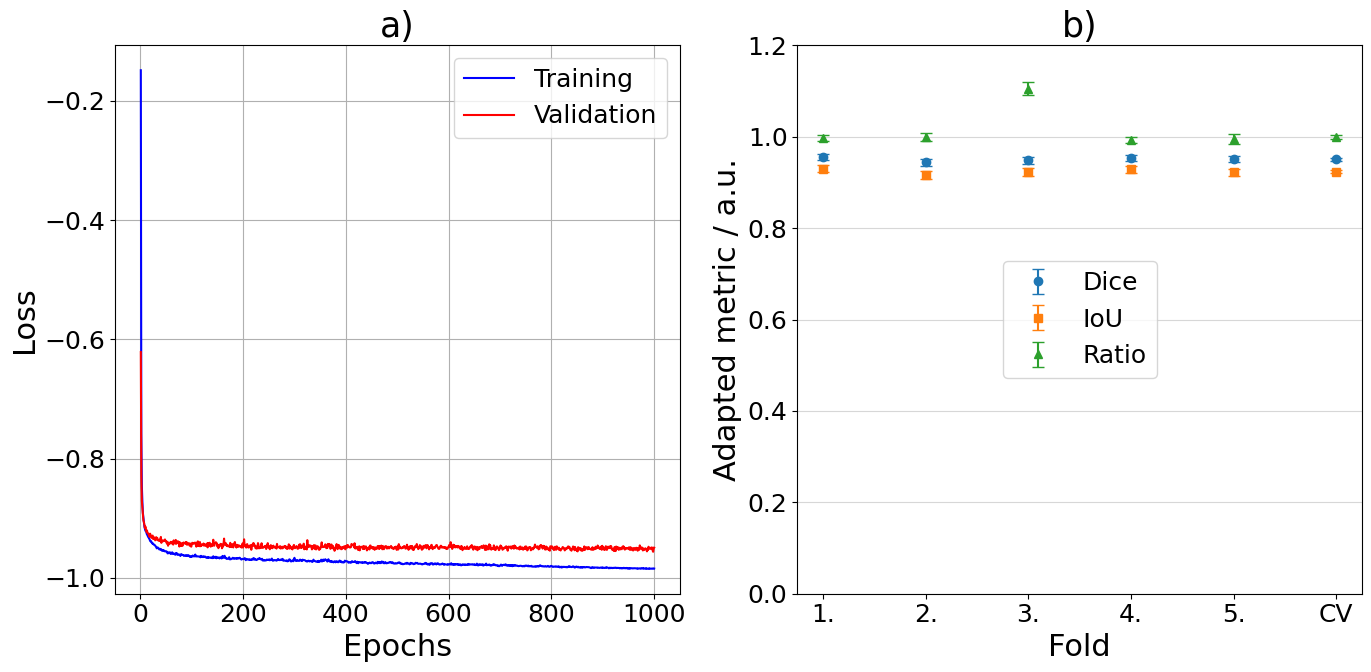

In [16]:
# ----------------------------- METRICS DATA -----------------------------

x = np.array(["1.","2.","3.","4.","5.","CV"])

metric_colors = {
    "Dice": "tab:blue",
    "IoU": "tab:orange",
    "Ratio": "tab:green"
}

# Prepare arrays for plotting
# Dice
Val_Dice_means_matrix = []
Val_Dice_errors_matrix = []
# IoU
Val_IoU_means_matrix = []
Val_IoU_errors_matrix = []
#Ratio
Val_Ratio_means_matrix = []
Val_Ratio_errors_matrix = []

# extract the Dice, IoU, Ratio, each mean and SEM
for i in dataset_ids_one_selected:
    ######Dice
    ########################################################
    Val_Dice_means = Val_Dice_corrected[i].iloc[Val_col_indices].values # adapt metric here
    Val_Dice_sems = Val_Dice_corrected_SEM[i].iloc[Val_col_indices].values #adapt metric here
    ########################################################
    Val_Dice_means_matrix.append(Val_Dice_means)
    Val_Dice_errors_matrix.append(Val_Dice_sems)
    ######IoU
    ########################################################
    Val_IoU_means = Val_IoU_corrected[i].iloc[Val_col_indices].values # adapt metric here
    Val_IoU_sems = Val_IoU_corrected_SEM[i].iloc[Val_col_indices].values #adapt metric here
    ########################################################
    Val_IoU_means_matrix.append(Val_IoU_means)
    Val_IoU_errors_matrix.append(Val_IoU_sems)
    ######Ratio
    ########################################################
    Val_Ratio_means = Val_Ratio_corrected[i].iloc[Val_col_indices].values # adapt metric here
    Val_Ratio_sems = Val_Ratio_corrected_SEM[i].iloc[Val_col_indices].values #adapt metric here
    ########################################################
    Val_Ratio_means_matrix.append(Val_Ratio_means)
    Val_Ratio_errors_matrix.append(Val_Ratio_sems)

#Dice
Val_Dice_means_matrix = np.array(Val_Dice_means_matrix)  # shape: (datasets, columns)
Val_Dice_errors_matrix = np.array(Val_Dice_errors_matrix)

#IoU
Val_IoU_means_matrix = np.array(Val_IoU_means_matrix)  # shape: (datasets, columns)
Val_IoU_errors_matrix = np.array(Val_IoU_errors_matrix)

#Ratio
Val_Ratio_means_matrix = np.array(Val_Ratio_means_matrix)  # shape: (datasets, columns)
Val_Ratio_errors_matrix = np.array(Val_Ratio_errors_matrix)


# Compute means and SEMs averaged over datasets
Dice_means_avg = Val_Dice_means_matrix.mean(axis=0)
Dice_sems_avg = Val_Dice_errors_matrix.mean(axis=0)

IoU_means_avg = Val_IoU_means_matrix.mean(axis=0)
IoU_sems_avg = Val_IoU_errors_matrix.mean(axis=0)

Ratio_means_avg = Val_Ratio_means_matrix.mean(axis=0)
Ratio_sems_avg = Val_Ratio_errors_matrix.mean(axis=0)


# ----------------------------- LOSS DATA -----------------------------

file_path = "fold1_training_log_2025_7_11_16_28_55.txt"  # Replace with your file path

num_expr = r'(-?(?:\d+\.\d+|\d+|\.\d+))'
train_re = re.compile(r'\btrain_loss\s*[:=]?\s*' + num_expr)
val_re   = re.compile(r'\bval_loss\s*[:=]?\s*'   + num_expr)

train_losses = []
val_losses = []

with open(file_path, 'r', encoding='utf-8') as f:
    for lineno, line in enumerate(f, 1):
        line = line.rstrip("\n")
        m = train_re.search(line)
        if m:
            try:
                train_losses.append(float(m.group(1)))
            except ValueError:
                print(f"Warning: could not parse train_loss number on line {lineno}: {line!r}")
        m = val_re.search(line)
        if m:
            try:
                val_losses.append(float(m.group(1)))
            except ValueError:
                print(f"Warning: could not parse val_loss number on line {lineno}: {line!r}")

print(f"Parsed {len(train_losses)} train_loss entries and {len(val_losses)} val_loss entries.")


# ----------------------------- COMBINED PLOTTING -----------------------------

fig, axes = plt.subplots(1, 2, figsize=(14, 7))  # two square-ish subplots side by side
ax1, ax2 = axes

# -------- RIGHT: Loss Plot --------
if len(train_losses) == 0 and len(val_losses) == 0:
    raise SystemExit("No losses found. Check your file path and keywords (train_loss / val_loss).")

if train_losses:
    ax1.plot(range(1, len(train_losses) + 1), train_losses, color='blue', label="Training")
if val_losses:
    ax1.plot(range(1, len(val_losses) + 1), val_losses, color='red', label="Validation")

ax1.set_xlabel("Epochs", fontsize=22)
ax1.set_ylabel("Loss", fontsize=22)
ax1.tick_params(axis='both', labelsize=18)
ax1.legend(fontsize=18)
ax1.set_title('a)', fontsize=25)
ax1.grid(True)
ax1.set_aspect('auto', adjustable='box')

# -------- LEFT: Metrics Plot --------
ax2.errorbar(x, Dice_means_avg, yerr=Dice_sems_avg, fmt='o',
             color=metric_colors["Dice"], markersize=6, capsize=4, label="Dice")
ax2.errorbar(x, IoU_means_avg, yerr=IoU_sems_avg, fmt='s',
             color=metric_colors["IoU"], markersize=6, capsize=4, label="IoU")
ax2.errorbar(x, Ratio_means_avg, yerr=Ratio_sems_avg, fmt='^',
             color=metric_colors["Ratio"], markersize=6, capsize=4, label="Ratio")

ax2.set_xticks(range(len(x)))
ax2.set_xticklabels(x, fontsize=18)
ax2.set_xlabel("Fold", fontsize=22)
ax2.set_ylabel("Adapted metric / a.u.", fontsize=22)
ax2.tick_params(axis='both', labelsize=18)
ax2.set_ylim(0, 1.2)
ax2.set_title('b)',fontsize=25)
ax2.grid(axis="y", linestyle="-", alpha=0.5)
ax2.legend(loc='center', fontsize=18)
ax2.set_aspect('auto', adjustable='box')



# -------- Formatting --------
plt.tight_layout()

# Save figure (side-by-side)
output_base = "Fig3" # <-- "Fig_Combined_Metrics_Loss", für PAPER "Fig3"
fig.savefig(f"{output_base}.pdf", dpi=300, bbox_inches="tight")
# fig.savefig(f"{output_base}.png", dpi=300, bbox_inches="tight")  # optional

plt.show()


# ----------------------------- OPTIONAL DIAGNOSTIC -----------------------------
if len(train_losses) != len(val_losses):
    print("\nNote: train and val counts differ.")
    print(" - If you expect them to match 1:1 per epoch, truncate to min length for alignment.")
    n_show = 5
    if train_losses:
        print("First train_losses:", train_losses[:n_show])
        print("Last  train_losses:", train_losses[-n_show:])
    if val_losses:
        print("First val_losses:  ", val_losses[:n_show])
        print("Last  val_losses:  ", val_losses[-n_show:])


## Figure 5 - Test binary metrics
### Dice, IoU, Ratio together in one plot 

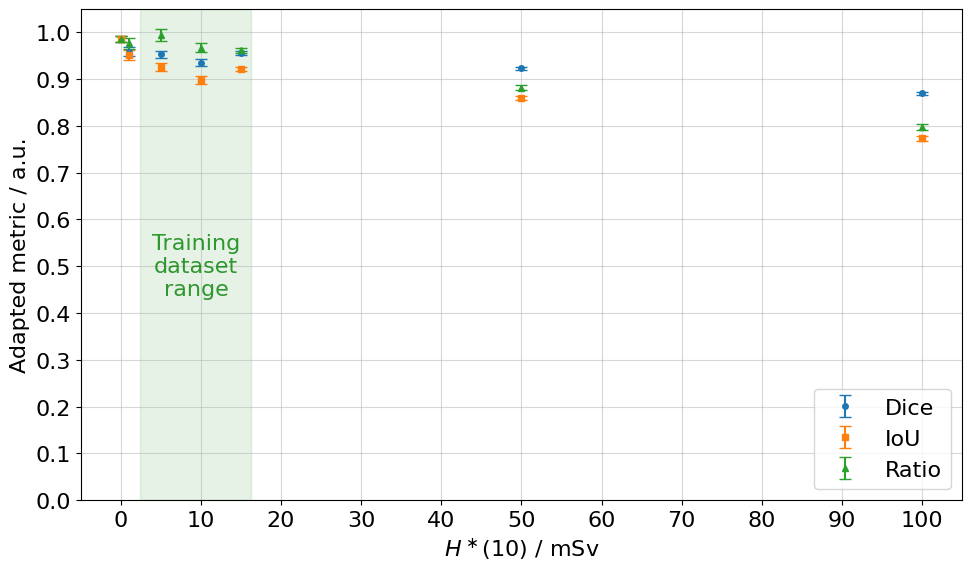

Adapted Dice mean: 0.9404 ± 0.0053
Adapted IoU mean: 0.9025 ± 0.0099
Adapted Ratio mean: 0.938 ± 0.0103


In [17]:
# Prepare arrays for plotting
# Dice
Dice_means_matrix = []
Dice_errors_matrix = []
Dice_dataset_means_matrix = []
Dice_dataset_errors_matrix = []
# IoU
IoU_means_matrix = []
IoU_errors_matrix = []
IoU_dataset_means_matrix = []
IoU_dataset_errors_matrix = []
#Ratio
Ratio_means_matrix = []
Ratio_errors_matrix = []
Ratio_dataset_means_matrix = []
Ratio_dataset_errors_matrix = []

# extract the Dice, IoU, Ratio, each mean and SEM
for i in dataset_ids_one_selected:
    ######Dice
    ########################################################
    Dice_means = Dice_corrected[i].iloc[col_indices].values # adapt metric here
    Dice_sems = Dice_corrected_SEM[i].iloc[col_indices].values #adapt metric here
    ########################################################
    Dice_means_matrix.append(Dice_means)
    Dice_errors_matrix.append(Dice_sems)
    # overall dataset mean
    ##########################################################
    Dice_dataset_means = Dice_dataset_mean[i].iloc[col_indices][1] #1 for dice, #2 for iou, #3 for ratio, #4 for deviation from ref
    Dice_dataset_sems= Dice_dataset_SEM[i].iloc[col_indices][1] #1 for dice, #2 for iou, #3 for ratio, #4 for deviation from ref
    ###########################################################
    Dice_dataset_means_matrix.append(Dice_dataset_means)
    Dice_dataset_errors_matrix.append(Dice_dataset_sems)
    ######IoU
    ########################################################
    IoU_means = IoU_corrected[i].iloc[col_indices].values # adapt metric here
    IoU_sems = IoU_corrected_SEM[i].iloc[col_indices].values #adapt metric here
    ########################################################
    IoU_means_matrix.append(IoU_means)
    IoU_errors_matrix.append(IoU_sems)
    # overall dataset mean
    ##########################################################
    IoU_dataset_means = IoU_dataset_mean[i].iloc[col_indices][2] #1 for dice, #2 for iou, #3 for ratio, #4 for deviation from ref
    IoU_dataset_sems= IoU_dataset_SEM[i].iloc[col_indices][2] #1 for dice, #2 for iou, #3 for ratio, #4 for deviation from ref
    ###########################################################
    IoU_dataset_means_matrix.append(IoU_dataset_means)
    IoU_dataset_errors_matrix.append(IoU_dataset_sems)
    ######Ratio
    ########################################################
    Ratio_means = Ratio_corrected[i].iloc[col_indices].values # adapt metric here
    Ratio_sems = Ratio_corrected_SEM[i].iloc[col_indices].values #adapt metric here
    ########################################################
    Ratio_means_matrix.append(Ratio_means)
    Ratio_errors_matrix.append(Ratio_sems)
    # overall dataset mean
    ##########################################################
    Ratio_dataset_means = Ratio_dataset_mean[i].iloc[col_indices][3] #1 for dice, #2 for iou, #3 for ratio, #4 for deviation from ref
    Ratio_dataset_sems= Ratio_dataset_SEM[i].iloc[col_indices][3] #1 for dice, #2 for iou, #3 for ratio, #4 for deviation from ref
    ###########################################################
    Ratio_dataset_means_matrix.append(Ratio_dataset_means)
    Ratio_dataset_errors_matrix.append(Ratio_dataset_sems)
#Dice
Dice_means_matrix = np.array(Dice_means_matrix)  # shape: (datasets, columns)
Dice_errors_matrix = np.array(Dice_errors_matrix)
Dice_dataset_means_matrix = np.array(Dice_dataset_means_matrix)  
Dice_dataset_errors_matrix = np.array(Dice_dataset_errors_matrix)
#IoU
IoU_means_matrix = np.array(IoU_means_matrix)  # shape: (datasets, columns)
IoU_errors_matrix = np.array(IoU_errors_matrix)
IoU_dataset_means_matrix = np.array(IoU_dataset_means_matrix)  
IoU_dataset_errors_matrix = np.array(IoU_dataset_errors_matrix)
#Ratio
Ratio_means_matrix = np.array(Ratio_means_matrix)  # shape: (datasets, columns)
Ratio_errors_matrix = np.array(Ratio_errors_matrix)
Ratio_dataset_means_matrix = np.array(Ratio_dataset_means_matrix)  
Ratio_dataset_errors_matrix = np.array(Ratio_dataset_errors_matrix)

# X-axis: actual dose values
x = np.array(doses)

fig, ax = plt.subplots(figsize=(10, 6))

# ---- Dice ----
ax.errorbar(
    x,
    Dice_means_matrix.mean(axis=0),  # average across datasets
    yerr=Dice_errors_matrix.mean(axis=0),
    fmt="o", markersize=4, capsize=4, label="Dice"
)

# ---- IoU ----
ax.errorbar(
    x,
    IoU_means_matrix.mean(axis=0),
    yerr=IoU_errors_matrix.mean(axis=0),
    fmt="s", markersize=4, capsize=4, label="IoU"
)

# ---- Ratio ----
ax.errorbar(
    x,
    Ratio_means_matrix.mean(axis=0),
    yerr=Ratio_errors_matrix.mean(axis=0),
    fmt="^", markersize=4, capsize=4, label="Ratio"
)

# Format axes
ax.set_xlabel(r"$\mathit{H}^\ast(10)$ / mSv")
ax.set_ylabel("Adapted metric / a.u.")
ax.set_xlim(-5, 105)        # full dose range
ax.set_ylim(0, 1.05)     # adjust depending on your metrics

##### dose range of training data
# Add transparent shaded area
ax.axvspan(2.72-0.28, 15.3+1.0, color='green', alpha=0.1) #in MeV

# Add text inside the shaded region
ax.text(
    (2.72-0.28 + 15.3+1.0) / 2, 0.5,  # centered horizontally, y = 0.95 (near top)
    "Training\ndataset\nrange",
    color='green',
    fontsize=16,
    ha='center', va='center',
    alpha=0.8,
    rotation=0
)

#dose lines
#line1=15.3
#width1=1.0
#line2=10.1
#width2=0.7
#line3=5.0
#width3=0.4
#line4=9.7
#width4=0.8
#line5=5.1
#width5=0.4
#line6=2.72
#width6=0.28

#plt.axvline(x=line1, color='green', linestyle=':')
#plt.axvline(x=line2, color='green', linestyle=':')
#plt.axvline(x=line3, color='green', linestyle=':')
#plt.axvline(x=line4, color='green', linestyle=':')
#plt.axvline(x=line5, color='green', linestyle=':')
#plt.axvline(x=line6, color='green', linestyle=':')

#dose widths
#plt.axvspan(line1-width1, line1+width1, color='green', alpha=0.2) 
#plt.axvspan(line2-width2, line2+width2, color='green', alpha=0.2)
#plt.axvspan(line3-width3, line3+width3, color='green', alpha=0.2)
#plt.axvspan(line4-width4, line4+width4, color='green', alpha=0.2)
#plt.axvspan(line5-width5, line5+width5, color='green', alpha=0.2)
#plt.axvspan(line6-width6, line6+width6, color='green', alpha=0.2)


# X-ticks every 10
xticks = np.arange(0, 110, 10)  # from 0 to 100 in steps of 10
ax.set_xticks(xticks)
# Y-ticks every 0.1
yticks = np.arange(0, 1.05, 0.1)  # from 0 to 1.0 in steps of 0.1
ax.set_yticks(yticks)
ax.grid(axis="both", linestyle="-", alpha=0.5)

ax.legend()

fig.tight_layout()


# ---------------- SAVE FIGURE ----------------
output_base = "Fig5" # <-- "Fig_Binary_Metrics_Test", für PAPER "Fig5"

# Speichern als PNG (für Vorschau)
#fig.savefig(f"{output_base}.png", dpi=300, bbox_inches="tight")

# Speichern als PDF (Vektorgraphik, für Publikation)
fig.savefig(f"{output_base}.pdf", dpi=300, bbox_inches="tight")

# Speichern als JPG (falls gewünscht, Format erzwingen)
#fig.savefig(f"{output_base}.jpg", format="jpg", dpi=300, bbox_inches="tight")

plt.show()

# ---------------- PRINT MEANS (not plotted) ----------------
print("Adapted Dice mean:", round(Dice_dataset_means_matrix.mean(),4), "±", round(Dice_dataset_errors_matrix.mean(),4))
print("Adapted IoU mean:", round(IoU_dataset_means_matrix.mean(),4), "±", round(IoU_dataset_errors_matrix.mean(),4))
print("Adapted Ratio mean:", round(Ratio_dataset_means_matrix.mean(),4), "±", round(Ratio_dataset_errors_matrix.mean(),4))


## Figure 7 - Test dosimetry metrics

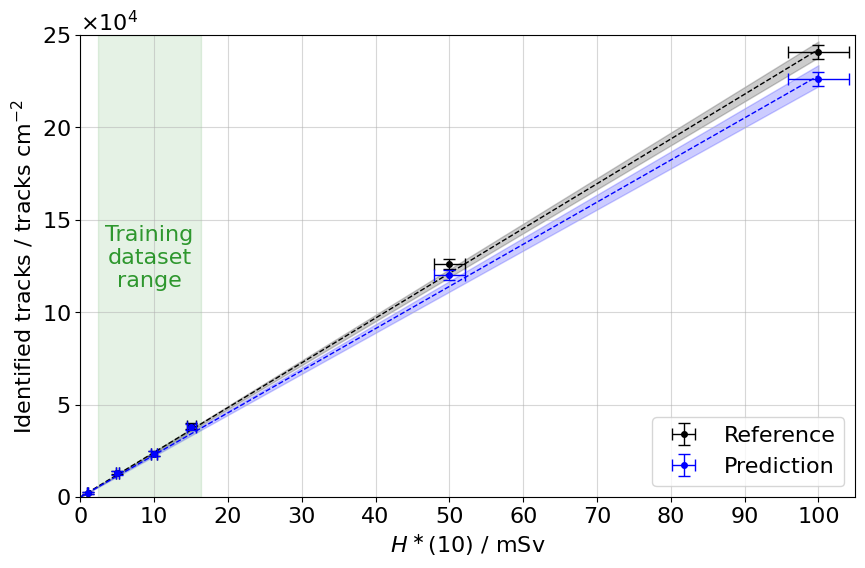

FIT THROUGH ALL POINTS
Exact values:
Python-Reference: slope = 2422.35 ± 16.80, R² = 0.999760
Dataset 010: slope = 2280.01 ± 22.30, R² = 0.999522
Sigma deviation(Dataset 010, Python-Reference) = 5.1 σ
Relative deviation(Dataset 010, Python-Reference) = (5.9 ± 1.1)%
-----------------------------------------------------
Rounded values:
Python-Reference: slope = 2420.0 ± 20.0, R² = 0.9998
Dataset 010: slope = 2280.0 ± 20.0, R² = 0.9995
Sigma deviation(Dataset 010, Python-Reference) = 4.9 σ
Relative deviation(Dataset 010, Python-Reference) = (5.8 ± 1.1)%


In [18]:
# ---------------- HELPER FUNCTIONS ----------------
####### LINEAR FIT FUNCTION ########################
def weighted_linear_fit(x, y, yerr):
    """
    Perform linear regression and compute slope, intercept, errors and R².
    Returns dict with fit results and fitted y values.
    """
    relative_err = yerr / y
    weights = 1/(relative_err**2)

    model = sm.WLS(y, x, weights=weights)
    results = model.fit()

    slope = results.params[0]
    slope_err = results.bse[0]
    r_squared = results.rsquared

    return {
        "slope": slope,
        "slope_err": slope_err,
        "R2": r_squared
    }

######### PLOT FUNCTION FOR DATA ##############################
def plot_dataset(ax, x, y, xerr, yerr, color, label):
    """
    Scatter plot with error bars.
    """
    ax.errorbar(
        x, y,
        xerr=xerr, yerr=yerr,
        color=color,
        linestyle='none',
        marker='o',
        markersize=4,
        capsize=4,
        linewidth=1,
        label=label
    )

####### PLOT FUNCTION FOR FIT AND 95% CI ############################
def plot_fit_with_ci(ax, x, fit_results, color, fit_label=None, ci=0.95, ci_label=None):
    """
    Plot linear fit and 95% confidence interval.
    """
    # fit
    slope, slope_err = fit_results["slope"], fit_results["slope_err"]
    # x-range for fit and CI visualization
    x_min, x_max, x_steps = 0, 100, 100
    x_fit = np.linspace(x_min, x_max, x_steps)
    y_fit = slope * x_fit

    # confidence interval
    n = len(x)
    alpha = 1-ci
    t_val = stats.t.ppf(1-alpha/2, df=n-1) # since we have one fitting parameter
    y_se = x_fit * slope_err
    y_ci_upper = y_fit + t_val*y_se
    y_ci_lower = y_fit - t_val*y_se
    
    # plot fit and CI
    ax.plot(x_fit, y_fit, color=color, linestyle='--', linewidth=1, label=fit_label)
    ax.fill_between(x_fit, y_ci_lower, y_ci_upper, color=color, alpha=0.2, label=ci_label)


# ---------------- PLOTTING PIPELINE ----------------
fig, ax = plt.subplots(figsize=(10, 6))
color_ref = 'black'
color_pred = ['red', 'blue']


# Prepare arrays for plotting
means_matrix_minsize_pred = []
errors_matrix_minsize_pred = []
means_matrix_minsize_ref = []
errors_matrix_minsize_ref = []

for i in dataset_ids_one_selected:
    ########################################################
    means_minsize_pred = Tracks_predicted_minsize[i].iloc[col_indices].values # adapt metric here
    sems_minsize_pred = Tracks_predicted_minsize_SEM[i].iloc[col_indices].values # adapt metric here
    means_minsize_ref = Tracks_reference_minsize[i].iloc[col_indices].values # adapt metric here
    sems_minsize_ref = Tracks_reference_minsize_SEM[i].iloc[col_indices].values # adapt metric here
    ########################################################
    means_matrix_minsize_pred.append(means_minsize_pred)
    errors_matrix_minsize_pred.append(sems_minsize_pred)
    means_matrix_minsize_ref.append(means_minsize_ref)
    errors_matrix_minsize_ref.append(sems_minsize_ref)

means_matrix_minsize_pred = np.array(means_matrix_minsize_pred)
errors_matrix_minsize_pred = np.array(errors_matrix_minsize_pred)
means_matrix_minsize_ref = np.array(means_matrix_minsize_ref)
errors_matrix_minsize_ref = np.array(errors_matrix_minsize_ref)

# converting into track density
readout_area = 0.01**2 * (504/512)**2 # in cm² and scaling factor
track_density_minsize_pred = means_matrix_minsize_pred / readout_area
track_density_minsize_pred_errors = errors_matrix_minsize_pred / readout_area
track_density_minsize_ref = means_matrix_minsize_ref / readout_area
track_density_minsize_ref_errors = errors_matrix_minsize_ref / readout_area

# --- Python Reference ---
x_ref = doses[1:]
xerr_ref = doses_err[1:]
y_ref = np.array(track_density_minsize_ref[0, 1:], dtype=float) - np.array(track_density_minsize_ref[0, 0], dtype=float)
yerr_ref = (np.array(track_density_minsize_ref_errors[0, 1:], dtype=float)**2 +
            np.array(track_density_minsize_ref_errors[0, 1:], dtype=float)**2)**0.5

plot_dataset(ax, x_ref, y_ref, xerr_ref, yerr_ref, "black", "Reference")
fit_results_minsize_ref = {"Python-Reference": weighted_linear_fit(x_ref, y_ref, yerr_ref)}
plot_fit_with_ci(ax, x_ref, fit_results_minsize_ref["Python-Reference"], "black", None, 0.95, None)

# --- Predicted Datasets ---
fit_results_minsize_pred = {}
for idx, dataset_id in enumerate(dataset_ids_one_selected):
    x = np.array(doses[1:], dtype=float)
    xerr = x * 0.083/2
    y = np.array(track_density_minsize_pred[idx, 1:], dtype=float) - np.array(track_density_minsize_pred[idx, 0], dtype=float)
    yerr = (np.array(track_density_minsize_pred_errors[idx, 1:], dtype=float)**2 +
            np.array(track_density_minsize_pred_errors[idx, 1:], dtype=float)**2)**0.5

    label = f"Prediction"
    plot_dataset(ax, x, y, xerr, yerr, color_pred[idx+1], label)
    
    res = weighted_linear_fit(x, y, yerr)
    fit_results_minsize_pred[f"Dataset {dataset_id:03}"] = res
    plot_fit_with_ci(ax, x, res, color_pred[idx+1], None, 0.95, None)

# Add transparent shaded area
ax.axvspan(2.72-0.28, 15.3+1.0, color='green', alpha=0.1) #in MeV

# Add text in shaded area
ax.text(
    (2.72-0.28 + 15.3+1.0) / 2,  # horizontal midpoint
    0.5 * ax.get_ylim()[1],  # 95% of the vertical range
    "Training\ndataset\nrange",
    color='green',
    fontsize=16,
    ha='center',
    va='center',
    alpha=0.8
)

# ---------------- FORMATTING ----------------
ax.set_xlim(0, 105)
ax.set_ylim(0, 250000)
ax.set_xlabel(r"$\mathit{H}^\ast(10)$ / mSv")
ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
ax.set_ylabel("Identified tracks / tracks cm$^{-2}$")
ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax.ticklabel_format(axis='y', style='sci', scilimits=(4,4))
ax.set_title("")
ax.grid(linestyle='-', alpha=0.5)
ax.legend(loc="best")

# ---------------- INSET: BAR PLOT OF SLOPES ----------------
all_results_minsize = {**fit_results_minsize_ref, **fit_results_minsize_pred}

labels_minsize = list(all_results_minsize.keys())
slopes_minsize = [res["slope"] for res in all_results_minsize.values()]
errors_minsize = [res["slope_err"] for res in all_results_minsize.values()]

colors = []
for label in labels_minsize:
    if label == "MATLAB-Reference":
        colors.append("green")
    elif label == "Python-Reference":
        colors.append("black")
    else:
        dataset_id = int(label.split()[1])
        idx = dataset_ids_one_selected.index(dataset_id)
        colors.append(color_pred[idx+1])
+1
x_bar = np.arange(len(slopes_minsize))
width = 0.6

plt.show()

##### not rounded ####################
print("FIT THROUGH ALL POINTS")
print("Exact values:")
# ---------------- PRINT FIT PARAMETERS ----------------
for key, params in {**fit_results_minsize_ref, **fit_results_minsize_pred}.items():
    print(f"{key}: slope = {params['slope']:.2f} ± {params['slope_err']:.2f}, "
          f"R² = {params['R2']:.6f}")
    
# ---------------- SIGMA DEVIATION ----------------
# Slopes and errors
slope_dataset010 = fit_results_minsize_pred["Dataset 010"]["slope"]
err_dataset010   = fit_results_minsize_pred["Dataset 010"]["slope_err"]
slope_python_ref = fit_results_minsize_ref["Python-Reference"]["slope"]
err_python_ref   = fit_results_minsize_ref["Python-Reference"]["slope_err"]

# Gaussian error propagation
sigma_dev_010_python = abs(slope_dataset010 - slope_python_ref) / np.sqrt(err_dataset010**2 + err_python_ref**2)
print(f"Sigma deviation(Dataset 010, Python-Reference) = {sigma_dev_010_python:.1f} σ")

# Percent deviation |a-b|/b=|(a/b)-1|, rounded
relative_dev_010_python = abs((slope_dataset010/slope_python_ref)-1)*100
relative_dev_010_python_err = np.sqrt((err_dataset010/slope_python_ref)**2+(slope_dataset010*err_python_ref/(slope_python_ref**2))**2)*100
print(f"Relative deviation(Dataset 010, Python-Reference) = ({relative_dev_010_python:.1f} ± {relative_dev_010_python_err:.1f})%")

print("-----------------------------------------------------")
print("Rounded values:")
#### rounded values ##########################
slope_dataset010_rounded = round(slope_dataset010,-1) 
err_dataset010_rounded = round(err_dataset010,-1)  
slope_python_ref_rounded = round(slope_python_ref,-1)
err_python_ref_rounded = round(err_python_ref,-1)

# ---------------- PRINT FIT PARAMETERS ----------------
for key, params in {**fit_results_minsize_ref, **fit_results_minsize_pred}.items():
    print(f"{key}: slope = {round(params['slope'],-1)} ± {round(params['slope_err'],-1)}, "
          f"R² = {params['R2']:.4f}")


# Gaussian error propagation, rounded
sigma_dev_010_python_rounded = abs(slope_dataset010_rounded - slope_python_ref_rounded) / np.sqrt(err_dataset010_rounded**2 + err_python_ref_rounded**2)
print(f"Sigma deviation(Dataset 010, Python-Reference) = {sigma_dev_010_python_rounded:.1f} σ")

# Percent deviation |a-b|/b=|(a/b)-1|, rounded
relative_dev_010_python_rounded = abs((slope_dataset010_rounded/slope_python_ref_rounded)-1)*100
relative_dev_010_python_err_rounded = np.sqrt((err_dataset010_rounded/slope_python_ref_rounded)**2+(slope_dataset010_rounded*err_python_ref_rounded/(slope_python_ref_rounded**2))**2)*100
print(f"Relative deviation(Dataset 010, Python-Reference) = ({relative_dev_010_python_rounded:.1f} ± {relative_dev_010_python_err_rounded:.1f})%")

# ---------------- SAVE FIGURE ----------------
output_base = "Fig7" # <-- "Fig_Calibration_Curve_Prediction", für PAPER "Fig7"

# Speichern als PNG (für Vorschau)
#fig.savefig(f"{output_base}.png", dpi=300, bbox_inches="tight")

# Speichern als PDF (Vektorgraphik, für Publikation)
fig.savefig(f"{output_base}.pdf", dpi=300, bbox_inches="tight")

# Speichern als JPG (falls gewünscht, Format erzwingen)
#fig.savefig(f"{output_base}.jpg", format="jpg", dpi=300, bbox_inches="tight")

## Figure 7.5 - Test dosimetry metrics - confined region

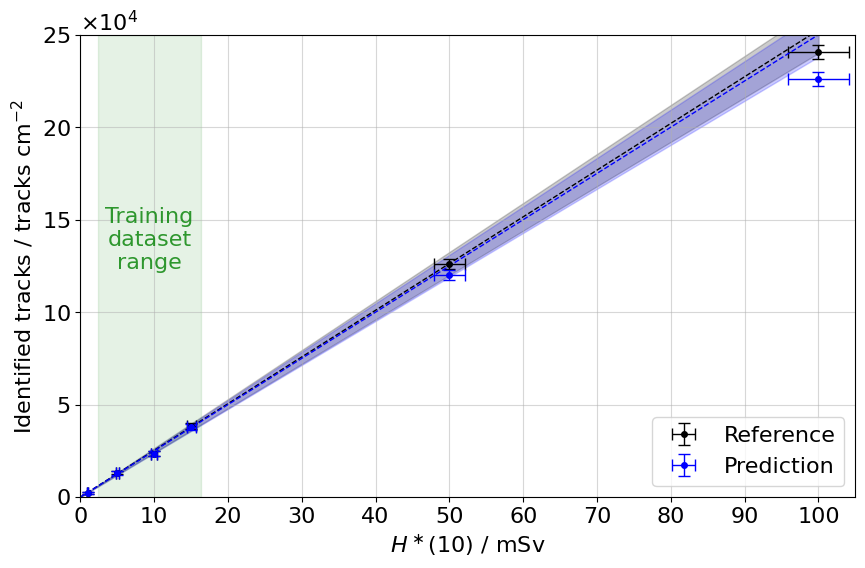

FIT THROUGH TRAINING DATASET RANGE ONLY
Exact values:
Python-Reference: slope = 2527.51 ± 48.63, R² = 0.998891
Dataset 010: slope = 2502.00 ± 46.42, R² = 0.998969
Sigma deviation(Dataset 010, Python-Reference) = 0.4 σ
Relative deviation(Dataset 010, Python-Reference) = (1.0 ± 2.6)%
-----------------------------------------------------
Rounded values:
Python-Reference: slope = 2530.0 ± 50.0, R² = 0.9989
Dataset 010: slope = 2500.0 ± 50.0, R² = 0.9990
Sigma deviation(Dataset 010, Python-Reference) = 0.4 σ
Relative deviation(Dataset 010, Python-Reference) = (1.2 ± 2.8)%


In [19]:
# ---------------- HELPER FUNCTIONS ----------------
####### LINEAR FIT FUNCTION ########################
def weighted_linear_fit(x, y, yerr):
    """
    Perform linear regression and compute slope, intercept, errors and R².
    Returns dict with fit results and fitted y values.
    """
    relative_err = yerr / y
    weights = 1 / (relative_err**2)

    model = sm.WLS(y, x, weights=weights)
    results = model.fit()

    slope = results.params[0]
    slope_err = results.bse[0]
    r_squared = results.rsquared

    return {
        "slope": slope,
        "slope_err": slope_err,
        "R2": r_squared
    }

######### PLOT FUNCTION FOR DATA ##############################
def plot_dataset(ax, x, y, xerr, yerr, color, label):
    """
    Scatter plot with error bars.
    """
    ax.errorbar(
        x, y,
        xerr=xerr, yerr=yerr,
        color=color,
        linestyle='none',
        marker='o',
        markersize=4,
        capsize=4,
        linewidth=1,
        label=label
    )

####### PLOT FUNCTION FOR FIT AND 95% CI ############################
def plot_fit_with_ci(ax, x, fit_results, color, fit_label=None, ci=0.95, ci_label=None):
    """
    Plot linear fit and 95% confidence interval.
    """
    slope, slope_err = fit_results["slope"], fit_results["slope_err"]

    # Fit line x-range
    x_min, x_max, x_steps = 0, 100, 100
    x_fit = np.linspace(x_min, x_max, x_steps)
    y_fit = slope * x_fit

    # Confidence interval
    n = len(x)
    alpha = 1 - ci
    t_val = stats.t.ppf(1 - alpha / 2, df=n - 1)
    y_se = x_fit * slope_err
    y_ci_upper = y_fit + t_val * y_se
    y_ci_lower = y_fit - t_val * y_se

    # Plot fit and CI
    ax.plot(x_fit, y_fit, color=color, linestyle='--', linewidth=1, label=fit_label)
    ax.fill_between(x_fit, y_ci_lower, y_ci_upper, color=color, alpha=0.2, label=ci_label)


# ---------------- PLOTTING PIPELINE ----------------
fig, ax = plt.subplots(figsize=(10, 6))
color_ref = 'black'
color_pred = ['red', 'blue']

# Prepare arrays for plotting
means_matrix_minsize_pred = []
errors_matrix_minsize_pred = []
means_matrix_minsize_ref = []
errors_matrix_minsize_ref = []

for i in dataset_ids_one_selected:
    ########################################################
    means_minsize_pred = Tracks_predicted_minsize[i].iloc[col_indices].values
    sems_minsize_pred = Tracks_predicted_minsize_SEM[i].iloc[col_indices].values
    means_minsize_ref = Tracks_reference_minsize[i].iloc[col_indices].values
    sems_minsize_ref = Tracks_reference_minsize_SEM[i].iloc[col_indices].values
    ########################################################
    means_matrix_minsize_pred.append(means_minsize_pred)
    errors_matrix_minsize_pred.append(sems_minsize_pred)
    means_matrix_minsize_ref.append(means_minsize_ref)
    errors_matrix_minsize_ref.append(sems_minsize_ref)

means_matrix_minsize_pred = np.array(means_matrix_minsize_pred)
errors_matrix_minsize_pred = np.array(errors_matrix_minsize_pred)
means_matrix_minsize_ref = np.array(means_matrix_minsize_ref)
errors_matrix_minsize_ref = np.array(errors_matrix_minsize_ref)

# Convert into track density
readout_area = 0.01**2 * (504 / 512)**2  # in cm² and scaling factor
track_density_minsize_pred = means_matrix_minsize_pred / readout_area
track_density_minsize_pred_errors = errors_matrix_minsize_pred / readout_area
track_density_minsize_ref = means_matrix_minsize_ref / readout_area
track_density_minsize_ref_errors = errors_matrix_minsize_ref / readout_area

# --- Python Reference ---
x_ref = np.array(doses[1:], dtype=float)
xerr_ref = np.array(doses_err[1:], dtype=float)
y_ref = np.array(track_density_minsize_ref[0, 1:], dtype=float) - np.array(track_density_minsize_ref[0, 0], dtype=float)
yerr_ref = (np.array(track_density_minsize_ref_errors[0, 1:], dtype=float)**2 +
            np.array(track_density_minsize_ref_errors[0, 1:], dtype=float)**2)**0.5

plot_dataset(ax, x_ref, y_ref, xerr_ref, yerr_ref, "black", "Reference")

# --- Fit only 5, 10, 15 mSv ---  ####################### <<< MODIFIED ###############################################
fit_mask = np.isin(x_ref, [1, 5, 10, 15]) ################ HERE ##################
x_fit_ref = x_ref[fit_mask]
y_fit_ref = y_ref[fit_mask]
yerr_fit_ref = yerr_ref[fit_mask]

fit_results_minsize_ref = {"Python-Reference": weighted_linear_fit(x_fit_ref, y_fit_ref, yerr_fit_ref)}
plot_fit_with_ci(ax, x_ref, fit_results_minsize_ref["Python-Reference"], "black", None, 0.95, None)

# --- Predicted Datasets ---
fit_results_minsize_pred = {}
for idx, dataset_id in enumerate(dataset_ids_one_selected):
    x = np.array(doses[1:], dtype=float)
    xerr = x * 0.083 / 2
    y = np.array(track_density_minsize_pred[idx, 1:], dtype=float) - np.array(track_density_minsize_pred[idx, 0], dtype=float)
    yerr = (np.array(track_density_minsize_pred_errors[idx, 1:], dtype=float)**2 +
            np.array(track_density_minsize_pred_errors[idx, 1:], dtype=float)**2)**0.5

    label = f"Prediction"
    plot_dataset(ax, x, y, xerr, yerr, color_pred[idx+1], label)

    # --- Fit only 5, 10, 15 mSv ---  ####################### <<< MODIFIED ###############################################
    fit_mask = np.isin(x, [1, 5, 10, 15]) ################ HERE ##################
    x_fit = x[fit_mask]
    y_fit = y[fit_mask]
    yerr_fit = yerr[fit_mask]

    res = weighted_linear_fit(x_fit, y_fit, yerr_fit)
    fit_results_minsize_pred[f"Dataset {dataset_id:03}"] = res
    plot_fit_with_ci(ax, x, res, color_pred[idx+1], None, 0.95, None)
    
# Add transparent shaded area
ax.axvspan(2.72-0.28, 15.3+1.0, color='green', alpha=0.1) #in MeV

# Add text in shaded area
ax.text(
    (2.72-0.28 + 15.3+1.0) / 2,  # horizontal midpoint
    0.5 * ax.get_ylim()[1],  # 95% of the vertical range
    "Training\ndataset\nrange",
    color='green',
    fontsize=16,
    ha='center',
    va='center',
    alpha=0.8
)

# ---------------- FORMATTING ----------------
ax.set_xlim(0, 105)
ax.set_ylim(0, 250000)
ax.set_xlabel(r"$\mathit{H}^\ast(10)$ / mSv")
ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
ax.set_ylabel("Identified tracks / tracks cm$^{-2}$")
ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax.ticklabel_format(axis='y', style='sci', scilimits=(4,4))
ax.set_title("")
ax.grid(linestyle='-', alpha=0.5)
ax.legend(loc="best")

# ---------------- INSET: BAR PLOT OF SLOPES ----------------
all_results_minsize = {**fit_results_minsize_ref, **fit_results_minsize_pred}

labels_minsize = list(all_results_minsize.keys())
slopes_minsize = [res["slope"] for res in all_results_minsize.values()]
errors_minsize = [res["slope_err"] for res in all_results_minsize.values()]

colors = []
for label in labels_minsize:
    if label == "MATLAB-Reference":
        colors.append("green")
    elif label == "Python-Reference":
        colors.append("black")
    else:
        dataset_id = int(label.split()[1])
        idx = dataset_ids_one_selected.index(dataset_id)
        colors.append(color_pred[idx+1])

x_bar = np.arange(len(slopes_minsize))
width = 0.6

plt.show()

##### not rounded ####################
print("FIT THROUGH TRAINING DATASET RANGE ONLY")
print("Exact values:")
# ---------------- PRINT FIT PARAMETERS ----------------
for key, params in {**fit_results_minsize_ref, **fit_results_minsize_pred}.items():
    print(f"{key}: slope = {params['slope']:.2f} ± {params['slope_err']:.2f}, "
          f"R² = {params['R2']:.6f}")
    
# ---------------- SIGMA DEVIATION ----------------
# Slopes and errors
slope_dataset010 = fit_results_minsize_pred["Dataset 010"]["slope"]
err_dataset010   = fit_results_minsize_pred["Dataset 010"]["slope_err"]
slope_python_ref = fit_results_minsize_ref["Python-Reference"]["slope"]
err_python_ref   = fit_results_minsize_ref["Python-Reference"]["slope_err"]

# Gaussian error propagation
sigma_dev_010_python = abs(slope_dataset010 - slope_python_ref) / np.sqrt(err_dataset010**2 + err_python_ref**2)
print(f"Sigma deviation(Dataset 010, Python-Reference) = {sigma_dev_010_python:.1f} σ")

# Percent deviation |a-b|/b=|(a/b)-1|, rounded
relative_dev_010_python = abs((slope_dataset010/slope_python_ref)-1)*100
relative_dev_010_python_err = np.sqrt((err_dataset010/slope_python_ref)**2+(slope_dataset010*err_python_ref/(slope_python_ref**2))**2)*100
print(f"Relative deviation(Dataset 010, Python-Reference) = ({relative_dev_010_python:.1f} ± {relative_dev_010_python_err:.1f})%")

print("-----------------------------------------------------")
print("Rounded values:")
#### rounded values ##########################
slope_dataset010_rounded = round(slope_dataset010,-1) 
err_dataset010_rounded = round(err_dataset010,-1)  
slope_python_ref_rounded = round(slope_python_ref,-1)
err_python_ref_rounded = round(err_python_ref,-1)

# ---------------- PRINT FIT PARAMETERS ----------------
for key, params in {**fit_results_minsize_ref, **fit_results_minsize_pred}.items():
    print(f"{key}: slope = {round(params['slope'],-1)} ± {round(params['slope_err'],-1)}, "
          f"R² = {params['R2']:.4f}")

# Gaussian error propagation, rounded
sigma_dev_010_python_rounded = abs(slope_dataset010_rounded - slope_python_ref_rounded) / np.sqrt(err_dataset010_rounded**2 + err_python_ref_rounded**2)
print(f"Sigma deviation(Dataset 010, Python-Reference) = {sigma_dev_010_python_rounded:.1f} σ")

# Percent deviation |a-b|/b=|(a/b)-1|, rounded
relative_dev_010_python_rounded = abs((slope_dataset010_rounded/slope_python_ref_rounded)-1)*100
relative_dev_010_python_err_rounded = np.sqrt((err_dataset010_rounded/slope_python_ref_rounded)**2+(slope_dataset010_rounded*err_python_ref_rounded/(slope_python_ref_rounded**2))**2)*100
print(f"Relative deviation(Dataset 010, Python-Reference) = ({relative_dev_010_python_rounded:.1f} ± {relative_dev_010_python_err_rounded:.1f})%")

# ---------------- SAVE FIGURE ----------------
output_base = "Fig_Calibration_Curve_Prediction_Trainingrange"

# Speichern als PDF (Vektorgraphik, für Publikation)
#fig.savefig(f"{output_base}.pdf", dpi=300, bbox_inches="tight")


## Figure S1 - Adapted Ratio

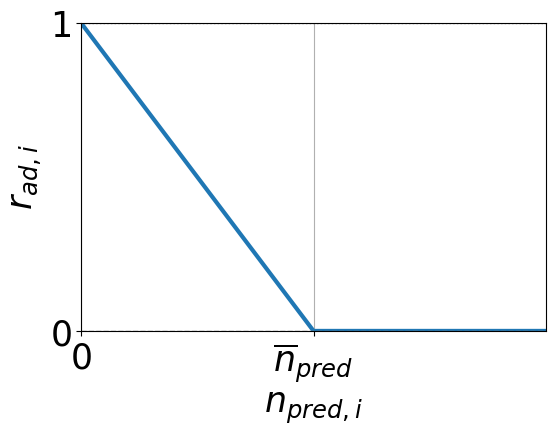

In [20]:
# Wertebereich für n_pred
n_pred = np.arange(0, 21, 1)

# Angenommener Mittelwert von n_pred für die Normalisierung
n_pred_mean = 10  

# Definition der Funktion R_cor für den Fall n_ref = 0
R_cor = np.zeros_like(n_pred, dtype=float)

# Fall 1: n_ref = 0, n_pred = 0 → R = 1
R_cor[0] = 1

# Fall 2: n_ref = 0, n_pred > 0 → R = max(1 - n_pred / n_pred_mean, 0)
mask = n_pred > 0
R_cor[mask] = np.maximum(1 - n_pred[mask] / n_pred_mean, 0)

plt.figure(figsize=(6,4))
plt.plot(n_pred, R_cor, marker="", linewidth=3)
plt.axhline(0, color="gray", linestyle="--", linewidth=1)
plt.axhline(1, color="gray", linestyle=":", linewidth=1)
plt.xlabel(r"$n_{pred,i}$",fontsize=25)
plt.ylabel(r"$r_{ad,i}$",fontsize=25)
plt.grid(True)

# X-Achsen-Ticks komplett entfernen
plt.gca().set_xticks([])
# Zwei spezielle Ticks setzen
plt.xticks([0, n_pred_mean], [r"$0$", r"$\overline{n}_{pred}$"],fontsize=25)
plt.yticks([0, 1], [r"$0$", r"$1$"],fontsize=25)
# Achsen exakt am Ursprung beginnen lassen
plt.xlim(0,20)   # keine Lücke links
plt.ylim(0,1) # keine Lücke unten

# ---------------- SAVE FIGURE ----------------#############################
fig = plt.gcf()  # <-- get current figure

output_base = "FigS1" # <-- "Fig_Adapted_Ratio", für PAPER "FigS1"
# Speichern als PNG (für Vorschau)
#fig.savefig(f"{output_base}.png", dpi=300, bbox_inches="tight")

# Speichern als PDF (Vektorgraphik, für Publikation)
fig.savefig(f"{output_base}.pdf", dpi=300, bbox_inches="tight")
#############################################################################

plt.show()

## Figure S2: Train and Validation loss plots

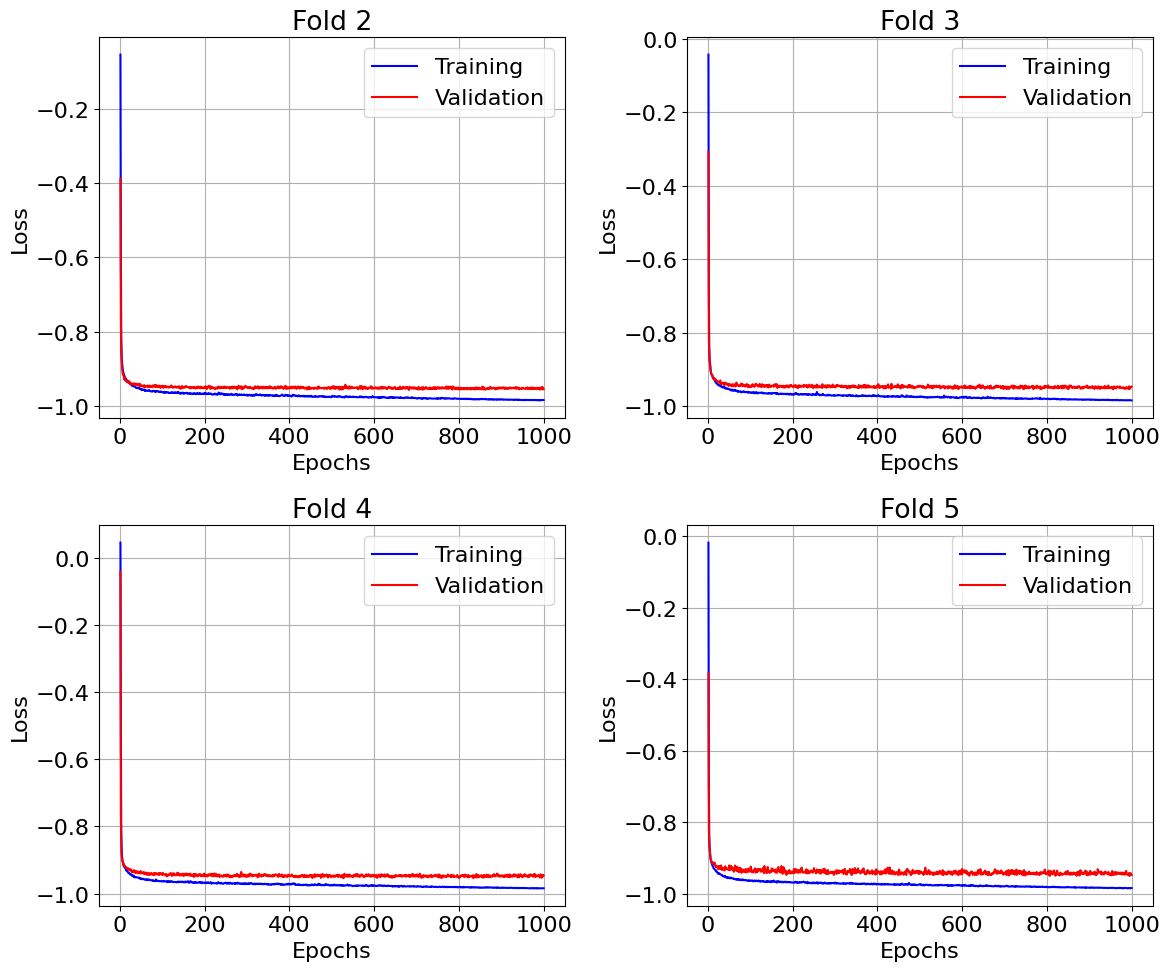

In [21]:
# List of your five files (replace with actual paths)
file_paths = [
    "fold2_training_log_2025_7_11_16_32_16.txt",
    "fold3_training_log_2025_7_11_16_32_16.txt",
    "fold4_training_log_2025_7_15_05_50_08.txt",
    "fold5_training_log_2025_7_11_16_32_14.txt",
]
# Corresponding subplot titles
titles = ["Fold 2", "Fold 3", "Fold 4", "Fold 5"]

# Regex for numbers after keyword
num_expr = r'(-?(?:\d+\.\d+|\d+|\.\d+))'
train_re = re.compile(r'\btrain_loss\s*[:=]?\s*' + num_expr)
val_re   = re.compile(r'\bval_loss\s*[:=]?\s*'   + num_expr)

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()  # flatten 2x2 array into list for easy indexing

for ax, file_path, title in zip(axes, file_paths, titles):
    train_losses, val_losses = [], []

    with open(file_path, 'r', encoding='utf-8') as f:
        for lineno, line in enumerate(f, 1):
            line = line.rstrip("\n")
            m = train_re.search(line)
            if m:
                try:
                    train_losses.append(float(m.group(1)))
                except ValueError:
                    print(f"Warning: could not parse train_loss in {file_path} line {lineno}")
            m = val_re.search(line)
            if m:
                try:
                    val_losses.append(float(m.group(1)))
                except ValueError:
                    print(f"Warning: could not parse val_loss in {file_path} line {lineno}")

    # Plot curves for this file
    if train_losses:
        ax.plot(range(1, len(train_losses) + 1), train_losses,
                color="blue", label="Training")
    if val_losses:
        ax.plot(range(1, len(val_losses) + 1), val_losses,
                color="red", label="Validation")

    ax.set_title(title)  # use short custom title
    ax.set_xlabel("Epochs")
    ax.set_ylabel("Loss")
    ax.grid(True)
    ax.legend()

plt.tight_layout()
plt.savefig("FigS2.pdf", dpi=300, bbox_inches="tight") # <-- "Fig_Loss_2x2", für PAPER "FigS2"
plt.show()



## Figure S4: Benchmark references

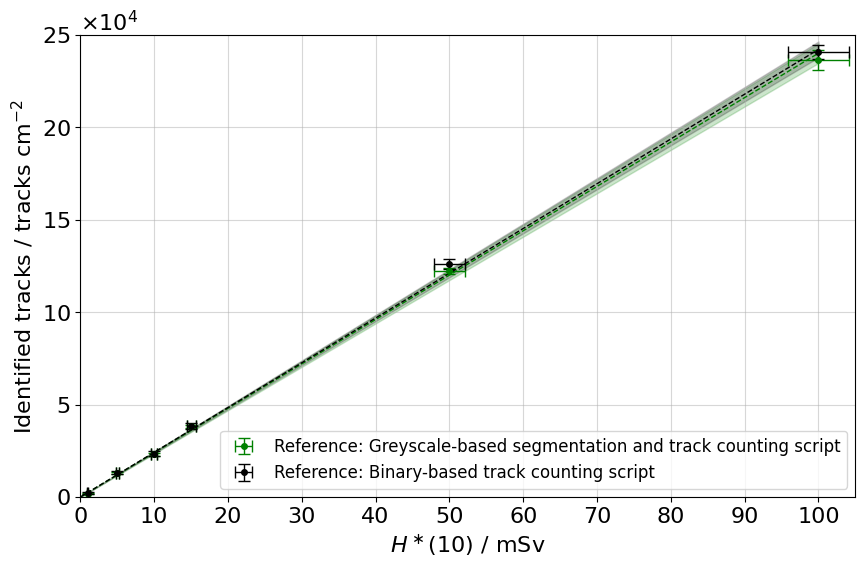

FIT THROUGH ALL POINTS
Exact values:
MATLAB-Reference: slope = 2401.87 ± 20.80, R² = 0.999625
Python-Reference: slope = 2422.35 ± 16.80, R² = 0.999760
Sigma deviation(MATLAB-Reference, Python-Reference) = 0.8 σ
Relative deviation(Python-Reference, MATLAB-Reference) = (0.9 ± 1.1)%
-----------------------------------------------------
Rounded values:
MATLAB-Reference: slope = 2400.0 ± 20.0, R² = 0.9996
Python-Reference: slope = 2420.0 ± 20.0, R² = 0.9998
Sigma deviation(MATLAB-Reference, Python-Reference) = 0.7 σ
Relative deviation(Python-Reference, MATLAB-Reference) = (0.8 ± 1.2)%


In [22]:
# ---------------- HELPER FUNCTIONS ----------------
####### LINEAR FIT FUNCTION ########################
def weighted_linear_fit(x, y, yerr):
    """
    Perform linear regression and compute slope, intercept, errors and R².
    Returns dict with fit results and fitted y values.
    """
    relative_err = yerr / y
    weights = 1/(relative_err**2)

    model = sm.WLS(y, x, weights=weights)
    results = model.fit()

    slope = results.params[0]
    slope_err = results.bse[0]
    r_squared = results.rsquared

    return {
        "slope": slope,
        "slope_err": slope_err,
        "R2": r_squared
    }

######### PLOT FUNCTION FOR DATA ##############################
def plot_dataset(ax, x, y, xerr, yerr, color, label):
    """
    Scatter plot with error bars.
    """
    ax.errorbar(
        x, y,
        xerr=xerr, yerr=yerr,
        color=color,
        linestyle='none',
        marker='o',
        markersize=4,
        capsize=4,
        linewidth=1,
        label=label
    )

####### PLOT FUNCTION FOR FIT AND 95% CI ############################
def plot_fit_with_ci(ax, x, fit_results, color, fit_label=None, ci=0.95, ci_label=None):
    """
    Plot linear fit and 95% confidence interval.
    """
    # fit
    slope, slope_err = fit_results["slope"], fit_results["slope_err"]
    # x-range for fit and CI visualization
    x_min, x_max, x_steps = 0, 100, 100
    x_fit = np.linspace(x_min, x_max, x_steps)
    y_fit = slope * x_fit

    # confidence interval
    n = len(x)
    alpha = 1-ci
    t_val = stats.t.ppf(1-alpha/2, df=n-1) # since we have one fitting parameter
    y_se = x_fit * slope_err
    y_ci_upper = y_fit + t_val*y_se
    y_ci_lower = y_fit - t_val*y_se
    
    # plot fit and CI
    ax.plot(x_fit, y_fit, color=color, linestyle='--', linewidth=1, label=fit_label)
    ax.fill_between(x_fit, y_ci_lower, y_ci_upper, color=color, alpha=0.2, label=ci_label)


# ---------------- PLOTTING PIPELINE ----------------
fig, ax = plt.subplots(figsize=(10, 6))

# Prepare arrays for plotting
means_matrix_minsize_pred = []
errors_matrix_minsize_pred = []
means_matrix_minsize_ref = []
errors_matrix_minsize_ref = []

for i in dataset_ids_one_selected:
    ########################################################
    means_minsize_pred = Tracks_predicted_minsize[i].iloc[col_indices].values # adapt metric here
    sems_minsize_pred = Tracks_predicted_minsize_SEM[i].iloc[col_indices].values # adapt metric here
    means_minsize_ref = Tracks_reference_minsize[i].iloc[col_indices].values # adapt metric here
    sems_minsize_ref = Tracks_reference_minsize_SEM[i].iloc[col_indices].values # adapt metric here
    ########################################################
    means_matrix_minsize_pred.append(means_minsize_pred)
    errors_matrix_minsize_pred.append(sems_minsize_pred)
    means_matrix_minsize_ref.append(means_minsize_ref)
    errors_matrix_minsize_ref.append(sems_minsize_ref)

means_matrix_minsize_pred = np.array(means_matrix_minsize_pred)
errors_matrix_minsize_pred = np.array(errors_matrix_minsize_pred)
means_matrix_minsize_ref = np.array(means_matrix_minsize_ref)
errors_matrix_minsize_ref = np.array(errors_matrix_minsize_ref)

# converting into track density
readout_area = 0.01**2 * (504/512)**2 # in cm² and scaling factor
track_density_minsize_pred = means_matrix_minsize_pred / readout_area
track_density_minsize_pred_errors = errors_matrix_minsize_pred / readout_area
track_density_minsize_ref = means_matrix_minsize_ref / readout_area
track_density_minsize_ref_errors = errors_matrix_minsize_ref / readout_area

# --- MATLAB Reference ---
x_matlab = doses_matlab
x_matlab_err = doses_matlab_err
y_matlab = trackdensity_matlab
y_matlab_err = trackdensity_matlab_err

plot_dataset(ax, x_matlab, y_matlab, x_matlab_err, y_matlab_err, "green", "Reference: Greyscale-based segmentation and track counting script")
fit_results_minsize_matlab = {"MATLAB-Reference": weighted_linear_fit(x_matlab, y_matlab, y_matlab_err)}
plot_fit_with_ci(ax, x_matlab, fit_results_minsize_matlab["MATLAB-Reference"], "green", None, 0.95, None)

# --- Python Reference ---
x_ref = doses[1:]
xerr_ref = doses_err[1:]
y_ref = np.array(track_density_minsize_ref[0, 1:], dtype=float) - np.array(track_density_minsize_ref[0, 0], dtype=float)
yerr_ref = (np.array(track_density_minsize_ref_errors[0, 1:], dtype=float)**2 +
            np.array(track_density_minsize_ref_errors[0, 1:], dtype=float)**2)**0.5

plot_dataset(ax, x_ref, y_ref, xerr_ref, yerr_ref, "black", "Reference: Binary-based track counting script")
fit_results_minsize_ref = {"Python-Reference": weighted_linear_fit(x_ref, y_ref, yerr_ref)}
plot_fit_with_ci(ax, x_ref, fit_results_minsize_ref["Python-Reference"], "black", None, 0.95, None)

## Add transparent shaded area
#ax.axvspan(2.72-0.28, 15.3+1.0, color='green', alpha=0.1, label="Training dataset range") #in MeV

# ---------------- FORMATTING ----------------
ax.set_xlim(0, 105)
ax.set_ylim(0, 250000)
ax.set_xlabel(r"$\mathit{H}^\ast(10)$ / mSv")
ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
ax.set_ylabel("Identified tracks / tracks cm$^{-2}$")
ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax.ticklabel_format(axis='y', style='sci', scilimits=(4,4))
ax.set_title("")
ax.grid(linestyle='-', alpha=0.5)
ax.legend(fontsize=12,loc="best")

# ---------------- INSET: BAR PLOT OF SLOPES ----------------
all_results_minsize = {**fit_results_minsize_matlab, **fit_results_minsize_ref}

labels_minsize = list(all_results_minsize.keys())
slopes_minsize = [res["slope"] for res in all_results_minsize.values()]
errors_minsize = [res["slope_err"] for res in all_results_minsize.values()]

colors = []
for label in labels_minsize:
    if label == "MATLAB-Reference":
        colors.append("green")
    elif label == "Python-Reference":
        colors.append("black")
    else:
        dataset_id = int(label.split()[1])
        idx = dataset_ids_one_selected.index(dataset_id)
        colors.append(color_pred[idx+1])
+1
x_bar = np.arange(len(slopes_minsize))
width = 0.6

plt.show()

#### not rounded values #############
print("FIT THROUGH ALL POINTS")
print("Exact values:")
# ---------------- PRINT FIT PARAMETERS ----------------
for key, params in {**fit_results_minsize_matlab, **fit_results_minsize_ref}.items():
    print(f"{key}: slope = {params['slope']:.2f} ± {params['slope_err']:.2f}, "
          f"R² = {params['R2']:.6f}")

# ---------------- SIGMA DEVIATION ----------------
# Slopes and errors
slope_python_ref = fit_results_minsize_ref["Python-Reference"]["slope"]
err_python_ref   = fit_results_minsize_ref["Python-Reference"]["slope_err"]
slope_matlab_ref = fit_results_minsize_matlab["MATLAB-Reference"]["slope"]
err_matlab_ref   = fit_results_minsize_matlab["MATLAB-Reference"]["slope_err"]

# Gaussian error propagation
sigma_dev_matlab_python = abs(slope_matlab_ref - slope_python_ref) / np.sqrt(err_matlab_ref**2 + err_python_ref**2)
print(f"Sigma deviation(MATLAB-Reference, Python-Reference) = {sigma_dev_matlab_python:.1f} σ")

# Percent deviation |a-b|/b=|(a/b)-1|, rounded
relative_dev = abs((slope_python_ref/slope_matlab_ref)-1)*100
relative_dev_err = np.sqrt((err_python_ref/slope_matlab_ref)**2+(slope_python_ref*err_matlab_ref/(slope_matlab_ref**2))**2)*100
print(f"Relative deviation(Python-Reference, MATLAB-Reference) = ({relative_dev:.1f} ± {relative_dev_err:.1f})%")

print("-----------------------------------------------------")
print("Rounded values:")

##### rounded values ###################
slope_python_ref_rounded = round(slope_python_ref,-1) 
err_python_ref_rounded = round(err_python_ref,-1)  
slope_matlab_ref_rounded = round(slope_matlab_ref,-1)
err_matlab_ref_rounded = round(err_matlab_ref,-1)

# ---------------- PRINT FIT PARAMETERS ----------------
for key, params in {**fit_results_minsize_matlab, **fit_results_minsize_ref}.items():
    print(f"{key}: slope = {round(params['slope'],-1)} ± {round(params['slope_err'],-1)}, "
          f"R² = {params['R2']:.4f}")

# Gaussian error propagation with paper values from Stefan 2400 +- 20, all values rounded
sigma_dev_matlab_python_paper_rounded = abs(slope_matlab_ref_rounded - slope_python_ref_rounded) / np.sqrt(err_matlab_ref_rounded**2 + err_python_ref_rounded**2)
print(f"Sigma deviation(MATLAB-Reference, Python-Reference) = {sigma_dev_matlab_python_paper_rounded:.1f} σ")

# Percent deviation |a-b|/b=|(a/b)-1|, rounded
relative_dev_rounded = abs((slope_python_ref_rounded/slope_matlab_ref_rounded)-1)*100
relative_dev_err_rounded = np.sqrt((err_python_ref_rounded/slope_matlab_ref_rounded)**2+(slope_python_ref_rounded*err_matlab_ref_rounded/(slope_matlab_ref_rounded**2))**2)*100
print(f"Relative deviation(Python-Reference, MATLAB-Reference) = ({relative_dev_rounded:.1f} ± {relative_dev_err_rounded:.1f})%")

# ---------------- SAVE FIGURE ---------------- 
output_base = "FigS4" # <-- "Fig_Calibration_Curve_References", für PAPER "FigS4"

# Speichern als PNG (für Vorschau)
#fig.savefig(f"{output_base}.png", dpi=300, bbox_inches="tight")

# Speichern als PDF (Vektorgraphik, für Publikation)
fig.savefig(f"{output_base}.pdf", dpi=300, bbox_inches="tight")

# Speichern als JPG (falls gewünscht, Format erzwingen)
#fig.savefig(f"{output_base}.jpg", format="jpg", dpi=300, bbox_inches="tight")

## Figure S4.5: Prediction vs. greyscale reference

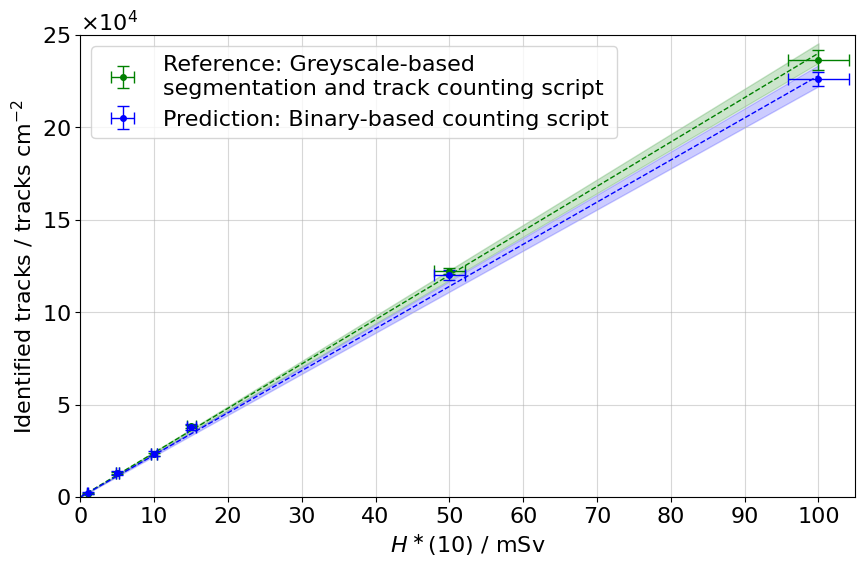

FIT THROUGH ALL POINTS
Exact values:
MATLAB-Reference: slope = 2401.87 ± 20.80, R² = 0.999625
Dataset 010: slope = 2280.01 ± 22.30, R² = 0.999522
Sigma deviation(Dataset 010, MATLAB-Reference) = 4.0 σ
Relative deviation(Dataset 010, MATLAB-Reference) = (5.1 ± 1.2)%
-----------------------------------------------------
Rounded values:
MATLAB-Reference: slope = 2400.0 ± 20.0, R² = 0.9996
Dataset 010: slope = 2280.0 ± 20.0, R² = 0.9995
Sigma deviation(Dataset 010, MATLAB-Reference) = 4.2 σ
Relative deviation(Dataset 010, MATLAB-Reference) = (5.0 ± 1.1)%


In [23]:
# ---------------- HELPER FUNCTIONS ----------------
####### LINEAR FIT FUNCTION ########################
def weighted_linear_fit(x, y, yerr):
    """
    Perform linear regression and compute slope, intercept, errors and R².
    Returns dict with fit results and fitted y values.
    """
    relative_err = yerr / y
    weights = 1/(relative_err**2)

    model = sm.WLS(y, x, weights=weights)
    results = model.fit()

    slope = results.params[0]
    slope_err = results.bse[0]
    r_squared = results.rsquared

    return {
        "slope": slope,
        "slope_err": slope_err,
        "R2": r_squared
    }

######### PLOT FUNCTION FOR DATA ##############################
def plot_dataset(ax, x, y, xerr, yerr, color, label):
    """
    Scatter plot with error bars.
    """
    ax.errorbar(
        x, y,
        xerr=xerr, yerr=yerr,
        color=color,
        linestyle='none',
        marker='o',
        markersize=4,
        capsize=4,
        linewidth=1,
        label=label
    )

####### PLOT FUNCTION FOR FIT AND 95% CI ############################
def plot_fit_with_ci(ax, x, fit_results, color, fit_label=None, ci=0.95, ci_label=None):
    """
    Plot linear fit and 95% confidence interval.
    """
    # fit
    slope, slope_err = fit_results["slope"], fit_results["slope_err"]
    # x-range for fit and CI visualization
    x_min, x_max, x_steps = 0, 100, 100
    x_fit = np.linspace(x_min, x_max, x_steps)
    y_fit = slope * x_fit

    # confidence interval
    n = len(x)
    alpha = 1-ci
    t_val = stats.t.ppf(1-alpha/2, df=n-1) # since we have one fitting parameter
    y_se = x_fit * slope_err
    y_ci_upper = y_fit + t_val*y_se
    y_ci_lower = y_fit - t_val*y_se
    
    # plot fit and CI
    ax.plot(x_fit, y_fit, color=color, linestyle='--', linewidth=1, label=fit_label)
    ax.fill_between(x_fit, y_ci_lower, y_ci_upper, color=color, alpha=0.2, label=ci_label)


# ---------------- PLOTTING PIPELINE ----------------
fig, ax = plt.subplots(figsize=(10, 6))

# Prepare arrays for plotting
means_matrix_minsize_pred = []
errors_matrix_minsize_pred = []
means_matrix_minsize_ref = []
errors_matrix_minsize_ref = []

for i in dataset_ids_one_selected:
    ########################################################
    means_minsize_pred = Tracks_predicted_minsize[i].iloc[col_indices].values # adapt metric here
    sems_minsize_pred = Tracks_predicted_minsize_SEM[i].iloc[col_indices].values # adapt metric here
    means_minsize_ref = Tracks_reference_minsize[i].iloc[col_indices].values # adapt metric here
    sems_minsize_ref = Tracks_reference_minsize_SEM[i].iloc[col_indices].values # adapt metric here
    ########################################################
    means_matrix_minsize_pred.append(means_minsize_pred)
    errors_matrix_minsize_pred.append(sems_minsize_pred)
    means_matrix_minsize_ref.append(means_minsize_ref)
    errors_matrix_minsize_ref.append(sems_minsize_ref)

means_matrix_minsize_pred = np.array(means_matrix_minsize_pred)
errors_matrix_minsize_pred = np.array(errors_matrix_minsize_pred)
means_matrix_minsize_ref = np.array(means_matrix_minsize_ref)
errors_matrix_minsize_ref = np.array(errors_matrix_minsize_ref)

# converting into track density
readout_area = 0.01**2 * (504/512)**2 # in cm² and scaling factor
track_density_minsize_pred = means_matrix_minsize_pred / readout_area
track_density_minsize_pred_errors = errors_matrix_minsize_pred / readout_area
track_density_minsize_ref = means_matrix_minsize_ref / readout_area
track_density_minsize_ref_errors = errors_matrix_minsize_ref / readout_area

# --- MATLAB Reference ---
x_matlab = doses_matlab
x_matlab_err = doses_matlab_err
y_matlab = trackdensity_matlab
y_matlab_err = trackdensity_matlab_err

plot_dataset(ax, x_matlab, y_matlab, x_matlab_err, y_matlab_err, "green", "Reference: Greyscale-based\nsegmentation and track counting script")
fit_results_minsize_matlab = {"MATLAB-Reference": weighted_linear_fit(x_matlab, y_matlab, y_matlab_err)}
plot_fit_with_ci(ax, x_matlab, fit_results_minsize_matlab["MATLAB-Reference"], "green", None, 0.95, None)


# --- Predicted Datasets ---
fit_results_minsize_pred = {}
for idx, dataset_id in enumerate(dataset_ids_one_selected):
    x = np.array(doses[1:], dtype=float)
    xerr = x * 0.083/2
    y = np.array(track_density_minsize_pred[idx, 1:], dtype=float) - np.array(track_density_minsize_pred[idx, 0], dtype=float)
    yerr = (np.array(track_density_minsize_pred_errors[idx, 1:], dtype=float)**2 +
            np.array(track_density_minsize_pred_errors[idx, 1:], dtype=float)**2)**0.5

    label = f"Prediction: Binary-based counting script"
    plot_dataset(ax, x, y, xerr, yerr, color_pred[idx+1], label)
    
    res = weighted_linear_fit(x, y, yerr)
    fit_results_minsize_pred[f"Dataset {dataset_id:03}"] = res
    plot_fit_with_ci(ax, x, res, color_pred[idx+1], None, 0.95, None)

## Add transparent shaded area
#ax.axvspan(2.72-0.28, 15.3+1.0, color='green', alpha=0.1, label="Training dataset range") #in MeV

# ---------------- FORMATTING ----------------
ax.set_xlim(0, 105)
ax.set_ylim(0, 250000)
ax.set_xlabel(r"$\mathit{H}^\ast(10)$ / mSv")
ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
ax.set_ylabel("Identified tracks / tracks cm$^{-2}$")
ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax.ticklabel_format(axis='y', style='sci', scilimits=(4,4))
ax.set_title("")
ax.grid(linestyle='-', alpha=0.5)
ax.legend(loc="best")

# ---------------- INSET: BAR PLOT OF SLOPES ----------------
all_results_minsize = {**fit_results_minsize_ref, **fit_results_minsize_pred}

labels_minsize = list(all_results_minsize.keys())
slopes_minsize = [res["slope"] for res in all_results_minsize.values()]
errors_minsize = [res["slope_err"] for res in all_results_minsize.values()]

colors = []
for label in labels_minsize:
    if label == "MATLAB-Reference":
        colors.append("green")
    elif label == "Python-Reference":
        colors.append("black")
    else:
        dataset_id = int(label.split()[1])
        idx = dataset_ids_one_selected.index(dataset_id)
        colors.append(color_pred[idx+1])
+1
x_bar = np.arange(len(slopes_minsize))
width = 0.6

plt.show()

##### not rounded ####################
print("FIT THROUGH ALL POINTS")
print("Exact values:")
# ---------------- PRINT FIT PARAMETERS ----------------
for key, params in {**fit_results_minsize_matlab, **fit_results_minsize_pred}.items():
    print(f"{key}: slope = {params['slope']:.2f} ± {params['slope_err']:.2f}, "
          f"R² = {params['R2']:.6f}")
    
# ---------------- SIGMA DEVIATION ----------------
# Slopes and errors
slope_dataset010 = fit_results_minsize_pred["Dataset 010"]["slope"]
err_dataset010   = fit_results_minsize_pred["Dataset 010"]["slope_err"]
slope_matlab_ref = fit_results_minsize_matlab["MATLAB-Reference"]["slope"]
err_matlab_ref   = fit_results_minsize_matlab["MATLAB-Reference"]["slope_err"]

# Gaussian error propagation
sigma_dev_010_matlab = abs(slope_dataset010 - slope_matlab_ref) / np.sqrt(err_dataset010**2 + err_matlab_ref**2)
print(f"Sigma deviation(Dataset 010, MATLAB-Reference) = {sigma_dev_010_matlab:.1f} σ")

# Percent deviation |a-b|/b=|(a/b)-1|, rounded
relative_dev_010_matlab = abs((slope_dataset010/slope_matlab_ref)-1)*100
relative_dev_010_matlab_err = np.sqrt((err_dataset010/slope_matlab_ref)**2+(slope_dataset010*err_matlab_ref/(slope_matlab_ref**2))**2)*100
print(f"Relative deviation(Dataset 010, MATLAB-Reference) = ({relative_dev_010_matlab:.1f} ± {relative_dev_010_matlab_err:.1f})%")

print("-----------------------------------------------------")
print("Rounded values:")
#### rounded values ##########################
slope_dataset010_rounded = round(slope_dataset010,-1) 
err_dataset010_rounded = round(err_dataset010,-1)  
slope_matlab_ref_rounded = round(slope_matlab_ref,-1)
err_matlab_ref_rounded = round(err_matlab_ref,-1)

# ---------------- PRINT FIT PARAMETERS ----------------
for key, params in {**fit_results_minsize_matlab, **fit_results_minsize_pred}.items():
    print(f"{key}: slope = {round(params['slope'],-1)} ± {round(params['slope_err'],-1)}, "
          f"R² = {params['R2']:.4f}")


# Gaussian error propagation, rounded
sigma_dev_010_matlab_rounded = abs(slope_dataset010_rounded - slope_matlab_ref_rounded) / np.sqrt(err_dataset010_rounded**2 + err_matlab_ref_rounded**2)
print(f"Sigma deviation(Dataset 010, MATLAB-Reference) = {sigma_dev_010_matlab_rounded:.1f} σ")

# Percent deviation |a-b|/b=|(a/b)-1|, rounded
relative_dev_010_matlab_rounded = abs((slope_dataset010_rounded/slope_matlab_ref_rounded)-1)*100
relative_dev_010_matlab_err_rounded = np.sqrt((err_dataset010_rounded/slope_matlab_ref_rounded)**2+(slope_dataset010_rounded*err_matlab_ref_rounded/(slope_matlab_ref_rounded**2))**2)*100
print(f"Relative deviation(Dataset 010, MATLAB-Reference) = ({relative_dev_010_matlab_rounded:.1f} ± {relative_dev_010_matlab_err_rounded:.1f})%")

# ---------------- SAVE FIGURE ----------------
output_base = "Fig_Calibration_Curve_Prediction_MATLAB"

# Speichern als PNG (für Vorschau)
#fig.savefig(f"{output_base}.png", dpi=300, bbox_inches="tight")

# Speichern als PDF (Vektorgraphik, für Publikation)
#fig.savefig(f"{output_base}.pdf", dpi=300, bbox_inches="tight")

# Speichern als JPG (falls gewünscht, Format erzwingen)
#fig.savefig(f"{output_base}.jpg", format="jpg", dpi=300, bbox_inches="tight")